In [4]:
import numpy as np
import math
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
from torch.autograd import Variable

torch.manual_seed(0)


# data loader function, return four datasets: train_data_x, train_data_y, test_data_x, test_data_y
def load_dataset():
    train_data_x = pd.read_pickle("train_data_x.pkl")

    train_data_y = pd.read_pickle("train_data_y.pkl")

    test_data_x = pd.read_pickle("test_data_x.pkl")

    test_data_y = pd.read_pickle("test_data_y.pkl")

    return train_data_x, train_data_y, test_data_x, test_data_y

# RCNN model
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        # Setting the functions that will be used in the ResNet
        self.conv1 = nn.Conv2d(3, 6, 5, 1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 2)
        self.conv2 = nn.Conv2d(6, 6, 1, 1)
        self.conv3 = nn.Conv2d(6, 6, 1, 1)
        self.conv4 = nn.Conv2d(6, 12, 5, 1)
        
        self.fc1 = nn.Linear(2028, 120)
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(64, 2)
        self.sigmoid = nn.Sigmoid()
    

    def forward(self, x):
        
        # The first convolutional layer
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # The second convolutional layer
        x = self.conv2(x)
        x = self.relu(x)
        # The third convolutional layer which has a residual connection with the forth
        residual = x
        x = self.conv3(x)
        x = self.relu(x)
        x += residual
        # The forth convolutional layer
        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)
        # The three fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        
        return x

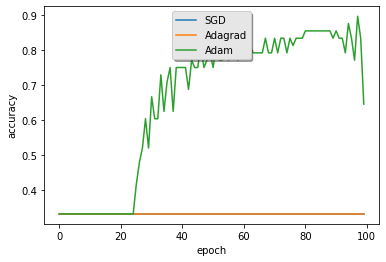

In [6]:
# model train
def model_train(rnn, train_data_x, train_data_y, test_data_x, test_data_y, optimizer, epoch):
    
    accuracy_all = []
    train_data_x, train_data_y = Variable(train_data_x), Variable(train_data_y)
    test_data_x, test_data_y = Variable(test_data_x), Variable(test_data_y)
    
    for iteration in range(epoch):
        
        rnn.train()   

        optimizer.zero_grad()
    
        train_data_x = train_data_x.to(dtype=torch.float)
        test_data_x = test_data_x.to(dtype=torch.float)

        train_output = rnn(train_data_x)
        test_output = rnn(test_data_x)

        train_data_y = train_data_y.squeeze()
        test_data_y = test_data_y.squeeze()

        result = loss_function(train_output, train_data_y)
        loss = loss_function(test_output, test_data_y)

        result.backward()
        optimizer.step()

        if epoch % 10 == 0:
            with torch.no_grad():
                output = rnn(test_data_x)
            
            softmax = torch.exp(output)
            prob = list(softmax.numpy())
            predictions = np.argmax(prob, axis = 1)
            
            accuracy_all.append(accuracy_score(test_data_y.T, predictions))
            
#             # printing the validation loss
#             print('Epoch : ',epoch, '\t', 'loss :', loss)
    return {'accuracy_all': accuracy_all}

if __name__ == '__main__':
    # load datasets
    train_data_x, train_data_y, test_data_x, test_data_y = load_dataset()
    
    # reshape the data from train_data_x: (205, 64, 64, 3) into (x, 3, 64, 64)
    train_data_x = train_data_x.transpose(0, 3, 1, 2)
    test_data_x = test_data_x.transpose(0, 3, 1, 2)
    
    # rescale data 
    train_data_x = train_data_x / 255.0
    test_data_x = test_data_x / 255.0

    # set the parameter
    batch_size = 5
    learning_rate = 0.0005
    epoch = 100

#     train_losses = []
#     test_losses = []
    
    train_data_x  = torch.from_numpy(train_data_x)
    train_data_y  = torch.from_numpy(train_data_y)

    test_data_x  = torch.from_numpy(test_data_x)
    test_data_y  = torch.from_numpy(test_data_y)
    
    # set the neural net work, optimize function, and the loss function
    rnn = Net()
    optimize_functions = [optim.SGD(rnn.parameters(), lr = 0.0005, momentum = 0.9, weight_decay = 0.0005),
                          optim.Adagrad(rnn.parameters(), lr = 0.001),
                          optim.Adam(rnn.parameters(), lr = 0.0005)]
    loss_function = nn.CrossEntropyLoss()
    
#     # model train
#     for epoch in range(epoch):
#         model_train(rnn, train_data_x, train_data_y, test_data_x, test_data_y, epoch)

#     # Convert the data into torch tensor
#     train_data_x = train_data_x.to(dtype=torch.float)
#     test_data_x = test_data_x.to(dtype=torch.float)
#     train_data_y = train_data_y.to(dtype=torch.float)
#     test_data_y = test_data_y.to(dtype=torch.float)
    
#     # Train data accuracy
#     rnn.eval()
#     with torch.no_grad():
#         output = rnn(train_data_x)
    
#     softmax = torch.exp(output)
#     prob = list(softmax.numpy())
#     train_predictions = np.argmax(prob, axis=1)
    
#     print("Train_accuracy:", accuracy_score(train_data_y.T, train_predictions))

#     # Test data accuracy
#     with torch.no_grad():
#         output = rnn(test_data_x)
    
#     softmax = torch.exp(output)
#     prob = list(softmax.numpy())
#     test_predictions = np.argmax(prob, axis=1)
    
#     print("Test_accuracy:", accuracy_score(test_data_y.T, test_predictions))

    models = {}
    for optimize_fun in optimize_functions:
        models[str(optimize_fun)] = model_train(rnn, train_data_x, train_data_y, test_data_x, test_data_y, optimize_fun, epoch)
    
    for optimize_fun in optimize_functions:
        plt.plot(models[str(optimize_fun)]['accuracy_all'], label = type(optimize_fun).__name__)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    legend = plt.legend(loc = 'upper center', shadow = True)
    frame = legend.get_frame()
    frame.set_facecolor('0.90')
    plt.show()